In [1]:
import re

import matplotlib.pyplot as plt
% matplotlib inline

import pandas as pd
from keras import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Activation
from keras.layers import Dense
from keras.layers import np
from keras.optimizers import RMSprop
from keras.utils import np_utils
from numpy import array
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

Using TensorFlow backend.


In [2]:
np.random.seed(1337)  # for reproducibility

def extract_max(input):
    return list(map(int, re.findall('\d+', input)))

def kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

In [3]:
train_df = pd.read_csv("../all/train.csv")
test_df = pd.read_csv("../all/test/test.csv")

In [4]:
train_df.head()

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed
0,2,Nibble,3,299,0,1,1,7,0,1,...,1,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1.0,2
1,2,No Name Yet,1,265,0,1,1,2,0,2,...,1,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2.0,0
2,1,Brisco,1,307,0,1,2,7,0,2,...,1,1,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,3422e4906,7.0,3
3,1,Miko,4,307,0,2,1,2,0,2,...,1,1,150,41401,9238e4f44c71a75282e62f7136c6b240,0,"Good guard dog, very alert, active, obedience ...",5842f1ff5,8.0,2
4,1,Hunter,1,307,0,1,1,0,0,2,...,1,1,0,41326,95481e953f8aed9ec3d16fc4509537e8,0,This handsome yet cute boy is up for adoption....,850a43f90,3.0,2


In [5]:
cat_cols = ['Type','Age','Breed1','Breed2', 'Gender', 'Color1', 'Color2', 'Color3', 'MaturitySize', 
          'FurLength', 'Vaccinated', 'Dewormed', 'Sterilized','Health', 'Quantity','State','VideoAmt','PhotoAmt']
num_cols = ['Fee']
text_cols = ['Description']

## Scale data

In [6]:
print('scaling num_cols')
for col in num_cols:
    print('scaling {}'.format(col))
    col_mean = train_df[col].mean()
    train_df[col].fillna(col_mean, inplace=True)
    test_df[col].fillna(col_mean, inplace=True)
    scaler = StandardScaler()
    train_df[col] = scaler.fit_transform(train_df[col].values.reshape(-1, 1))
    test_df[col] = scaler.transform(test_df[col].values.reshape(-1, 1))

tr_df, val_df = train_test_split(train_df, test_size=0.5, random_state=4)

y_train = np_utils.to_categorical(tr_df['AdoptionSpeed'], num_classes=5)
y_valid = np_utils.to_categorical(val_df['AdoptionSpeed'], num_classes=5)

cs = StandardScaler()
trainContinuous = cs.fit_transform(tr_df[cat_cols])
trainContinuous2 = cs.fit_transform(val_df[cat_cols])
trainContinuous3 = cs.fit_transform(test_df[cat_cols])
x_train = np.hstack([trainContinuous])
x_valid = np.hstack([trainContinuous2])
x_test = np.hstack([trainContinuous3])

scaling num_cols
scaling Fee


/Users/viteka/final_project/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/viteka/final_project/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/viteka/final_project/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/viteka/final_project/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/viteka/final_project/venv/lib/python3.6/site-packages/skl

## Define NN Model

In [7]:
model = Sequential([
        Dense(64, input_dim=18),
        Activation('relu'),
        Dense(32),
        Activation('relu'),
        Dense(32),
        Activation('relu'),
        Dense(16),
        Activation('relu'),
        Dense(5),
        Activation('sigmoid'),
    ])

rmsprop = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

# We add metrics to get more results you want to see
# categorical_crossentropy--mse
model.compile(optimizer=rmsprop,
              loss='mse',
              metrics=['accuracy'])

## Train NN

In [8]:
filepath = "../checkpoints/weights_image_categorical.hdf6"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
earlystopped = EarlyStopping(monitor='val_acc', min_delta=0.0001, patience=10, verbose=0, mode='max')
callbacks_list = [checkpoint]

for i in range(10):
    x_train1, x_train2, y_train1, y_train2 = train_test_split(x_train, y_train, test_size=0.2, random_state=i * 15)
    history = model.fit(x_train1, y_train1, validation_data=(x_train2, y_train2), epochs=100, batch_size=1000,
                        shuffle=True, callbacks=callbacks_list)

Train on 5996 samples, validate on 1500 samples
Epoch 1/100
5996/5996 [==============================] - 0s 68us/step - loss: 0.2319 - acc: 0.1791 - val_loss: 0.2098 - val_acc: 0.1907

Epoch 00001: val_acc improved from -inf to 0.19067, saving model to ../checkpoints/weights_image_categorical.hdf6
Epoch 2/100
5996/5996 [==============================] - 0s 3us/step - loss: 0.1998 - acc: 0.2050 - val_loss: 0.1876 - val_acc: 0.1987

Epoch 00002: val_acc improved from 0.19067 to 0.19867, saving model to ../checkpoints/weights_image_categorical.hdf6
Epoch 3/100
5996/5996 [==============================] - 0s 4us/step - loss: 0.1814 - acc: 0.2098 - val_loss: 0.1750 - val_acc: 0.2093

Epoch 00003: val_acc improved from 0.19867 to 0.20933, saving model to ../checkpoints/weights_image_categorical.hdf6
Epoch 4/100
5996/5996 [==============================] - 0s 4us/step - loss: 0.1709 - acc: 0.2263 - val_loss: 0.1671 - val_acc: 0.2200

Epoch 00004: val_acc improved from 0.20933 to 0.22000, savi

5996/5996 [==============================] - 0s 3us/step - loss: 0.1388 - acc: 0.4198 - val_loss: 0.1450 - val_acc: 0.3727

Epoch 00038: val_acc did not improve from 0.38200
Epoch 39/100
5996/5996 [==============================] - 0s 4us/step - loss: 0.1384 - acc: 0.4208 - val_loss: 0.1449 - val_acc: 0.3727

Epoch 00039: val_acc did not improve from 0.38200
Epoch 40/100
5996/5996 [==============================] - 0s 3us/step - loss: 0.1385 - acc: 0.4206 - val_loss: 0.1459 - val_acc: 0.3700

Epoch 00040: val_acc did not improve from 0.38200
Epoch 41/100
5996/5996 [==============================] - 0s 3us/step - loss: 0.1384 - acc: 0.4209 - val_loss: 0.1458 - val_acc: 0.3680

Epoch 00041: val_acc did not improve from 0.38200
Epoch 42/100
5996/5996 [==============================] - 0s 3us/step - loss: 0.1381 - acc: 0.4243 - val_loss: 0.1452 - val_acc: 0.3687

Epoch 00042: val_acc did not improve from 0.38200
Epoch 43/100
5996/5996 [==============================] - 0s 3us/step - loss: 


Epoch 00081: val_acc did not improve from 0.38400
Epoch 82/100
5996/5996 [==============================] - 0s 3us/step - loss: 0.1333 - acc: 0.4543 - val_loss: 0.1463 - val_acc: 0.3753

Epoch 00082: val_acc did not improve from 0.38400
Epoch 83/100
5996/5996 [==============================] - 0s 3us/step - loss: 0.1331 - acc: 0.4575 - val_loss: 0.1464 - val_acc: 0.3680

Epoch 00083: val_acc did not improve from 0.38400
Epoch 84/100
5996/5996 [==============================] - 0s 3us/step - loss: 0.1334 - acc: 0.4583 - val_loss: 0.1461 - val_acc: 0.3660

Epoch 00084: val_acc did not improve from 0.38400
Epoch 85/100
5996/5996 [==============================] - 0s 3us/step - loss: 0.1329 - acc: 0.4605 - val_loss: 0.1463 - val_acc: 0.3760

Epoch 00085: val_acc did not improve from 0.38400
Epoch 86/100
5996/5996 [==============================] - 0s 3us/step - loss: 0.1327 - acc: 0.4618 - val_loss: 0.1477 - val_acc: 0.3720

Epoch 00086: val_acc did not improve from 0.38400
Epoch 87/100
5

5996/5996 [==============================] - 0s 3us/step - loss: 0.1314 - acc: 0.4623 - val_loss: 0.1378 - val_acc: 0.4360

Epoch 00025: val_acc did not improve from 0.47200
Epoch 26/100
5996/5996 [==============================] - 0s 3us/step - loss: 0.1309 - acc: 0.4706 - val_loss: 0.1396 - val_acc: 0.4287

Epoch 00026: val_acc did not improve from 0.47200
Epoch 27/100
5996/5996 [==============================] - 0s 3us/step - loss: 0.1310 - acc: 0.4716 - val_loss: 0.1377 - val_acc: 0.4367

Epoch 00027: val_acc did not improve from 0.47200
Epoch 28/100
5996/5996 [==============================] - 0s 3us/step - loss: 0.1307 - acc: 0.4715 - val_loss: 0.1383 - val_acc: 0.4347

Epoch 00028: val_acc did not improve from 0.47200
Epoch 29/100
5996/5996 [==============================] - 0s 3us/step - loss: 0.1307 - acc: 0.4706 - val_loss: 0.1392 - val_acc: 0.4307

Epoch 00029: val_acc did not improve from 0.47200
Epoch 30/100
5996/5996 [==============================] - 0s 3us/step - loss: 

5996/5996 [==============================] - 0s 3us/step - loss: 0.1279 - acc: 0.4915 - val_loss: 0.1408 - val_acc: 0.4167

Epoch 00069: val_acc did not improve from 0.47200
Epoch 70/100
5996/5996 [==============================] - 0s 3us/step - loss: 0.1260 - acc: 0.5017 - val_loss: 0.1405 - val_acc: 0.4273

Epoch 00070: val_acc did not improve from 0.47200
Epoch 71/100
5996/5996 [==============================] - 0s 3us/step - loss: 0.1262 - acc: 0.4965 - val_loss: 0.1436 - val_acc: 0.4047

Epoch 00071: val_acc did not improve from 0.47200
Epoch 72/100
5996/5996 [==============================] - 0s 3us/step - loss: 0.1280 - acc: 0.4903 - val_loss: 0.1411 - val_acc: 0.4227

Epoch 00072: val_acc did not improve from 0.47200
Epoch 73/100
5996/5996 [==============================] - 0s 3us/step - loss: 0.1258 - acc: 0.5038 - val_loss: 0.1406 - val_acc: 0.4213

Epoch 00073: val_acc did not improve from 0.47200
Epoch 74/100
5996/5996 [==============================] - 0s 3us/step - loss: 

5996/5996 [==============================] - 0s 3us/step - loss: 0.1242 - acc: 0.5190 - val_loss: 0.1331 - val_acc: 0.4540

Epoch 00012: val_acc did not improve from 0.47467
Epoch 13/100
5996/5996 [==============================] - 0s 3us/step - loss: 0.1260 - acc: 0.5067 - val_loss: 0.1337 - val_acc: 0.4593

Epoch 00013: val_acc did not improve from 0.47467
Epoch 14/100
5996/5996 [==============================] - 0s 3us/step - loss: 0.1244 - acc: 0.5175 - val_loss: 0.1336 - val_acc: 0.4513

Epoch 00014: val_acc did not improve from 0.47467
Epoch 15/100
5996/5996 [==============================] - 0s 3us/step - loss: 0.1250 - acc: 0.5117 - val_loss: 0.1333 - val_acc: 0.4553

Epoch 00015: val_acc did not improve from 0.47467
Epoch 16/100
5996/5996 [==============================] - 0s 3us/step - loss: 0.1244 - acc: 0.5118 - val_loss: 0.1341 - val_acc: 0.4567

Epoch 00016: val_acc did not improve from 0.47467
Epoch 17/100
5996/5996 [==============================] - 0s 3us/step - loss: 

5996/5996 [==============================] - 0s 3us/step - loss: 0.1214 - acc: 0.5275 - val_loss: 0.1377 - val_acc: 0.4353

Epoch 00056: val_acc did not improve from 0.47467
Epoch 57/100
5996/5996 [==============================] - 0s 3us/step - loss: 0.1197 - acc: 0.5392 - val_loss: 0.1380 - val_acc: 0.4307

Epoch 00057: val_acc did not improve from 0.47467
Epoch 58/100
5996/5996 [==============================] - 0s 3us/step - loss: 0.1197 - acc: 0.5387 - val_loss: 0.1385 - val_acc: 0.4327

Epoch 00058: val_acc did not improve from 0.47467
Epoch 59/100
5996/5996 [==============================] - 0s 3us/step - loss: 0.1214 - acc: 0.5277 - val_loss: 0.1386 - val_acc: 0.4233

Epoch 00059: val_acc did not improve from 0.47467
Epoch 60/100
5996/5996 [==============================] - 0s 3us/step - loss: 0.1214 - acc: 0.5279 - val_loss: 0.1382 - val_acc: 0.4267

Epoch 00060: val_acc did not improve from 0.47467
Epoch 61/100
5996/5996 [==============================] - 0s 3us/step - loss: 

5996/5996 [==============================] - 0s 3us/step - loss: 0.1170 - acc: 0.5550 - val_loss: 0.1420 - val_acc: 0.4260

Epoch 00100: val_acc did not improve from 0.47467
Train on 5996 samples, validate on 1500 samples
Epoch 1/100
5996/5996 [==============================] - 0s 3us/step - loss: 0.1216 - acc: 0.5235 - val_loss: 0.1222 - val_acc: 0.5313

Epoch 00001: val_acc improved from 0.47467 to 0.53133, saving model to ../checkpoints/weights_image_categorical.hdf6
Epoch 2/100
5996/5996 [==============================] - 0s 3us/step - loss: 0.1213 - acc: 0.5307 - val_loss: 0.1241 - val_acc: 0.5353

Epoch 00002: val_acc improved from 0.53133 to 0.53533, saving model to ../checkpoints/weights_image_categorical.hdf6
Epoch 3/100
5996/5996 [==============================] - 0s 3us/step - loss: 0.1216 - acc: 0.5275 - val_loss: 0.1236 - val_acc: 0.5327

Epoch 00003: val_acc did not improve from 0.53533
Epoch 4/100
5996/5996 [==============================] - 0s 3us/step - loss: 0.1221 - 

5996/5996 [==============================] - 0s 3us/step - loss: 0.1168 - acc: 0.5567 - val_loss: 0.1307 - val_acc: 0.4887

Epoch 00043: val_acc did not improve from 0.53533
Epoch 44/100
5996/5996 [==============================] - 0s 3us/step - loss: 0.1165 - acc: 0.5594 - val_loss: 0.1318 - val_acc: 0.4740

Epoch 00044: val_acc did not improve from 0.53533
Epoch 45/100
5996/5996 [==============================] - 0s 3us/step - loss: 0.1177 - acc: 0.5489 - val_loss: 0.1311 - val_acc: 0.4800

Epoch 00045: val_acc did not improve from 0.53533
Epoch 46/100
5996/5996 [==============================] - 0s 3us/step - loss: 0.1172 - acc: 0.5564 - val_loss: 0.1318 - val_acc: 0.4813

Epoch 00046: val_acc did not improve from 0.53533
Epoch 47/100
5996/5996 [==============================] - 0s 3us/step - loss: 0.1159 - acc: 0.5594 - val_loss: 0.1311 - val_acc: 0.4827

Epoch 00047: val_acc did not improve from 0.53533
Epoch 48/100
5996/5996 [==============================] - 0s 3us/step - loss: 

5996/5996 [==============================] - 0s 3us/step - loss: 0.1142 - acc: 0.5737 - val_loss: 0.1359 - val_acc: 0.4593

Epoch 00087: val_acc did not improve from 0.53533
Epoch 88/100
5996/5996 [==============================] - 0s 3us/step - loss: 0.1131 - acc: 0.5777 - val_loss: 0.1375 - val_acc: 0.4527

Epoch 00088: val_acc did not improve from 0.53533
Epoch 89/100
5996/5996 [==============================] - 0s 3us/step - loss: 0.1140 - acc: 0.5674 - val_loss: 0.1354 - val_acc: 0.4680

Epoch 00089: val_acc did not improve from 0.53533
Epoch 90/100
5996/5996 [==============================] - 0s 3us/step - loss: 0.1129 - acc: 0.5776 - val_loss: 0.1357 - val_acc: 0.4653

Epoch 00090: val_acc did not improve from 0.53533
Epoch 91/100
5996/5996 [==============================] - 0s 3us/step - loss: 0.1141 - acc: 0.5710 - val_loss: 0.1402 - val_acc: 0.4460

Epoch 00091: val_acc did not improve from 0.53533
Epoch 92/100
5996/5996 [==============================] - 0s 3us/step - loss: 

5996/5996 [==============================] - 0s 3us/step - loss: 0.1138 - acc: 0.5710 - val_loss: 0.1259 - val_acc: 0.5113

Epoch 00030: val_acc did not improve from 0.55133
Epoch 31/100
5996/5996 [==============================] - 0s 3us/step - loss: 0.1118 - acc: 0.5836 - val_loss: 0.1260 - val_acc: 0.5073

Epoch 00031: val_acc did not improve from 0.55133
Epoch 32/100
5996/5996 [==============================] - 0s 3us/step - loss: 0.1139 - acc: 0.5707 - val_loss: 0.1275 - val_acc: 0.5140

Epoch 00032: val_acc did not improve from 0.55133
Epoch 33/100
5996/5996 [==============================] - 0s 3us/step - loss: 0.1133 - acc: 0.5727 - val_loss: 0.1261 - val_acc: 0.5167

Epoch 00033: val_acc did not improve from 0.55133
Epoch 34/100
5996/5996 [==============================] - 0s 3us/step - loss: 0.1126 - acc: 0.5796 - val_loss: 0.1274 - val_acc: 0.5053

Epoch 00034: val_acc did not improve from 0.55133
Epoch 35/100
5996/5996 [==============================] - 0s 3us/step - loss: 

5996/5996 [==============================] - 0s 3us/step - loss: 0.1100 - acc: 0.5926 - val_loss: 0.1331 - val_acc: 0.4720

Epoch 00074: val_acc did not improve from 0.55133
Epoch 75/100
5996/5996 [==============================] - 0s 3us/step - loss: 0.1093 - acc: 0.5936 - val_loss: 0.1331 - val_acc: 0.4707

Epoch 00075: val_acc did not improve from 0.55133
Epoch 76/100
5996/5996 [==============================] - 0s 3us/step - loss: 0.1111 - acc: 0.5876 - val_loss: 0.1321 - val_acc: 0.4820

Epoch 00076: val_acc did not improve from 0.55133
Epoch 77/100
5996/5996 [==============================] - 0s 3us/step - loss: 0.1081 - acc: 0.6016 - val_loss: 0.1313 - val_acc: 0.4900

Epoch 00077: val_acc did not improve from 0.55133
Epoch 78/100
5996/5996 [==============================] - 0s 3us/step - loss: 0.1082 - acc: 0.6011 - val_loss: 0.1327 - val_acc: 0.4813

Epoch 00078: val_acc did not improve from 0.55133
Epoch 79/100
5996/5996 [==============================] - 0s 3us/step - loss: 

5996/5996 [==============================] - 0s 3us/step - loss: 0.1094 - acc: 0.6006 - val_loss: 0.1190 - val_acc: 0.5520

Epoch 00017: val_acc did not improve from 0.58333
Epoch 18/100
5996/5996 [==============================] - 0s 3us/step - loss: 0.1119 - acc: 0.5836 - val_loss: 0.1244 - val_acc: 0.5207

Epoch 00018: val_acc did not improve from 0.58333
Epoch 19/100
5996/5996 [==============================] - 0s 3us/step - loss: 0.1107 - acc: 0.5986 - val_loss: 0.1190 - val_acc: 0.5473

Epoch 00019: val_acc did not improve from 0.58333
Epoch 20/100
5996/5996 [==============================] - 0s 3us/step - loss: 0.1098 - acc: 0.5987 - val_loss: 0.1232 - val_acc: 0.5193

Epoch 00020: val_acc did not improve from 0.58333
Epoch 21/100
5996/5996 [==============================] - 0s 3us/step - loss: 0.1113 - acc: 0.5859 - val_loss: 0.1193 - val_acc: 0.5527

Epoch 00021: val_acc did not improve from 0.58333
Epoch 22/100
5996/5996 [==============================] - 0s 3us/step - loss: 

5996/5996 [==============================] - 0s 3us/step - loss: 0.1077 - acc: 0.6096 - val_loss: 0.1256 - val_acc: 0.5167

Epoch 00061: val_acc did not improve from 0.58333
Epoch 62/100
5996/5996 [==============================] - 0s 3us/step - loss: 0.1060 - acc: 0.6182 - val_loss: 0.1257 - val_acc: 0.5127

Epoch 00062: val_acc did not improve from 0.58333
Epoch 63/100
5996/5996 [==============================] - 0s 3us/step - loss: 0.1067 - acc: 0.6154 - val_loss: 0.1325 - val_acc: 0.4860

Epoch 00063: val_acc did not improve from 0.58333
Epoch 64/100
5996/5996 [==============================] - 0s 3us/step - loss: 0.1092 - acc: 0.5962 - val_loss: 0.1264 - val_acc: 0.5133

Epoch 00064: val_acc did not improve from 0.58333
Epoch 65/100
5996/5996 [==============================] - 0s 3us/step - loss: 0.1060 - acc: 0.6197 - val_loss: 0.1269 - val_acc: 0.5173

Epoch 00065: val_acc did not improve from 0.58333
Epoch 66/100
5996/5996 [==============================] - 0s 3us/step - loss: 

5996/5996 [==============================] - 0s 3us/step - loss: 0.1071 - acc: 0.6164 - val_loss: 0.1119 - val_acc: 0.5780

Epoch 00004: val_acc did not improve from 0.58667
Epoch 5/100
5996/5996 [==============================] - 0s 3us/step - loss: 0.1091 - acc: 0.6072 - val_loss: 0.1152 - val_acc: 0.5507

Epoch 00005: val_acc did not improve from 0.58667
Epoch 6/100
5996/5996 [==============================] - 0s 3us/step - loss: 0.1094 - acc: 0.6017 - val_loss: 0.1138 - val_acc: 0.5613

Epoch 00006: val_acc did not improve from 0.58667
Epoch 7/100
5996/5996 [==============================] - 0s 3us/step - loss: 0.1086 - acc: 0.6057 - val_loss: 0.1139 - val_acc: 0.5607

Epoch 00007: val_acc did not improve from 0.58667
Epoch 8/100
5996/5996 [==============================] - 0s 3us/step - loss: 0.1076 - acc: 0.6126 - val_loss: 0.1152 - val_acc: 0.5640

Epoch 00008: val_acc did not improve from 0.58667
Epoch 9/100
5996/5996 [==============================] - 0s 3us/step - loss: 0.109

5996/5996 [==============================] - 0s 3us/step - loss: 0.1084 - acc: 0.6049 - val_loss: 0.1238 - val_acc: 0.5313

Epoch 00048: val_acc did not improve from 0.58667
Epoch 49/100
5996/5996 [==============================] - 0s 3us/step - loss: 0.1044 - acc: 0.6249 - val_loss: 0.1214 - val_acc: 0.5380

Epoch 00049: val_acc did not improve from 0.58667
Epoch 50/100
5996/5996 [==============================] - 0s 3us/step - loss: 0.1035 - acc: 0.6309 - val_loss: 0.1250 - val_acc: 0.5227

Epoch 00050: val_acc did not improve from 0.58667
Epoch 51/100
5996/5996 [==============================] - 0s 3us/step - loss: 0.1070 - acc: 0.6102 - val_loss: 0.1216 - val_acc: 0.5367

Epoch 00051: val_acc did not improve from 0.58667
Epoch 52/100
5996/5996 [==============================] - 0s 3us/step - loss: 0.1036 - acc: 0.6299 - val_loss: 0.1231 - val_acc: 0.5253

Epoch 00052: val_acc did not improve from 0.58667
Epoch 53/100
5996/5996 [==============================] - 0s 3us/step - loss: 

5996/5996 [==============================] - 0s 3us/step - loss: 0.1051 - acc: 0.6166 - val_loss: 0.1272 - val_acc: 0.5120

Epoch 00092: val_acc did not improve from 0.58667
Epoch 93/100
5996/5996 [==============================] - 0s 3us/step - loss: 0.1032 - acc: 0.6298 - val_loss: 0.1301 - val_acc: 0.4960

Epoch 00093: val_acc did not improve from 0.58667
Epoch 94/100
5996/5996 [==============================] - 0s 3us/step - loss: 0.1029 - acc: 0.6333 - val_loss: 0.1258 - val_acc: 0.5113

Epoch 00094: val_acc did not improve from 0.58667
Epoch 95/100
5996/5996 [==============================] - 0s 3us/step - loss: 0.1016 - acc: 0.6366 - val_loss: 0.1272 - val_acc: 0.5113

Epoch 00095: val_acc did not improve from 0.58667
Epoch 96/100
5996/5996 [==============================] - 0s 3us/step - loss: 0.1047 - acc: 0.6152 - val_loss: 0.1269 - val_acc: 0.5087

Epoch 00096: val_acc did not improve from 0.58667
Epoch 97/100
5996/5996 [==============================] - 0s 6us/step - loss: 

5996/5996 [==============================] - 0s 3us/step - loss: 0.1014 - acc: 0.6368 - val_loss: 0.1154 - val_acc: 0.5740

Epoch 00035: val_acc did not improve from 0.61867
Epoch 36/100
5996/5996 [==============================] - 0s 8us/step - loss: 0.1040 - acc: 0.6221 - val_loss: 0.1185 - val_acc: 0.5473

Epoch 00036: val_acc did not improve from 0.61867
Epoch 37/100
5996/5996 [==============================] - 0s 3us/step - loss: 0.1044 - acc: 0.6234 - val_loss: 0.1160 - val_acc: 0.5667

Epoch 00037: val_acc did not improve from 0.61867
Epoch 38/100
5996/5996 [==============================] - 0s 3us/step - loss: 0.1026 - acc: 0.6314 - val_loss: 0.1180 - val_acc: 0.5500

Epoch 00038: val_acc did not improve from 0.61867
Epoch 39/100
5996/5996 [==============================] - 0s 3us/step - loss: 0.1034 - acc: 0.6263 - val_loss: 0.1156 - val_acc: 0.5733

Epoch 00039: val_acc did not improve from 0.61867
Epoch 40/100
5996/5996 [==============================] - 0s 3us/step - loss: 

5996/5996 [==============================] - 0s 3us/step - loss: 0.1012 - acc: 0.6388 - val_loss: 0.1216 - val_acc: 0.5473

Epoch 00079: val_acc did not improve from 0.61867
Epoch 80/100
5996/5996 [==============================] - 0s 3us/step - loss: 0.1011 - acc: 0.6408 - val_loss: 0.1211 - val_acc: 0.5433

Epoch 00080: val_acc did not improve from 0.61867
Epoch 81/100
5996/5996 [==============================] - 0s 6us/step - loss: 0.1010 - acc: 0.6359 - val_loss: 0.1210 - val_acc: 0.5513

Epoch 00081: val_acc did not improve from 0.61867
Epoch 82/100
5996/5996 [==============================] - 0s 6us/step - loss: 0.1006 - acc: 0.6398 - val_loss: 0.1225 - val_acc: 0.5407

Epoch 00082: val_acc did not improve from 0.61867
Epoch 83/100
5996/5996 [==============================] - 0s 3us/step - loss: 0.1020 - acc: 0.6371 - val_loss: 0.1221 - val_acc: 0.5360

Epoch 00083: val_acc did not improve from 0.61867
Epoch 84/100
5996/5996 [==============================] - 0s 3us/step - loss: 


Epoch 00022: val_acc did not improve from 0.61867
Epoch 23/100
5996/5996 [==============================] - 0s 3us/step - loss: 0.1028 - acc: 0.6318 - val_loss: 0.1150 - val_acc: 0.5687

Epoch 00023: val_acc did not improve from 0.61867
Epoch 24/100
5996/5996 [==============================] - 0s 3us/step - loss: 0.1004 - acc: 0.6381 - val_loss: 0.1154 - val_acc: 0.5647

Epoch 00024: val_acc did not improve from 0.61867
Epoch 25/100
5996/5996 [==============================] - 0s 8us/step - loss: 0.1000 - acc: 0.6419 - val_loss: 0.1151 - val_acc: 0.5693

Epoch 00025: val_acc did not improve from 0.61867
Epoch 26/100
5996/5996 [==============================] - 0s 3us/step - loss: 0.0988 - acc: 0.6483 - val_loss: 0.1212 - val_acc: 0.5427

Epoch 00026: val_acc did not improve from 0.61867
Epoch 27/100
5996/5996 [==============================] - 0s 3us/step - loss: 0.1027 - acc: 0.6234 - val_loss: 0.1158 - val_acc: 0.5687

Epoch 00027: val_acc did not improve from 0.61867
Epoch 28/100
5


Epoch 00066: val_acc did not improve from 0.61867
Epoch 67/100
5996/5996 [==============================] - 0s 3us/step - loss: 0.0989 - acc: 0.6468 - val_loss: 0.1209 - val_acc: 0.5493

Epoch 00067: val_acc did not improve from 0.61867
Epoch 68/100
5996/5996 [==============================] - ETA: 0s - loss: 0.1004 - acc: 0.634 - 0s 5us/step - loss: 0.0984 - acc: 0.6526 - val_loss: 0.1241 - val_acc: 0.5327

Epoch 00068: val_acc did not improve from 0.61867
Epoch 69/100
5996/5996 [==============================] - 0s 3us/step - loss: 0.0989 - acc: 0.6481 - val_loss: 0.1199 - val_acc: 0.5547

Epoch 00069: val_acc did not improve from 0.61867
Epoch 70/100
5996/5996 [==============================] - 0s 3us/step - loss: 0.0971 - acc: 0.6554 - val_loss: 0.1256 - val_acc: 0.5207

Epoch 00070: val_acc did not improve from 0.61867
Epoch 71/100
5996/5996 [==============================] - 0s 3us/step - loss: 0.0993 - acc: 0.6459 - val_loss: 0.1197 - val_acc: 0.5587

Epoch 00071: val_acc did n

5996/5996 [==============================] - 0s 3us/step - loss: 0.1001 - acc: 0.6469 - val_loss: 0.1046 - val_acc: 0.6147

Epoch 00009: val_acc did not improve from 0.63467
Epoch 10/100
5996/5996 [==============================] - 0s 3us/step - loss: 0.1013 - acc: 0.6368 - val_loss: 0.1057 - val_acc: 0.6107

Epoch 00010: val_acc did not improve from 0.63467
Epoch 11/100
5996/5996 [==============================] - 0s 3us/step - loss: 0.0998 - acc: 0.6478 - val_loss: 0.1078 - val_acc: 0.5960

Epoch 00011: val_acc did not improve from 0.63467
Epoch 12/100
5996/5996 [==============================] - 0s 3us/step - loss: 0.1022 - acc: 0.6324 - val_loss: 0.1063 - val_acc: 0.6093

Epoch 00012: val_acc did not improve from 0.63467
Epoch 13/100
5996/5996 [==============================] - 0s 3us/step - loss: 0.0999 - acc: 0.6454 - val_loss: 0.1056 - val_acc: 0.6087

Epoch 00013: val_acc did not improve from 0.63467
Epoch 14/100
5996/5996 [==============================] - 0s 3us/step - loss: 

5996/5996 [==============================] - 0s 3us/step - loss: 0.0961 - acc: 0.6666 - val_loss: 0.1133 - val_acc: 0.5713

Epoch 00053: val_acc did not improve from 0.63467
Epoch 54/100
5996/5996 [==============================] - 0s 3us/step - loss: 0.0988 - acc: 0.6526 - val_loss: 0.1178 - val_acc: 0.5613

Epoch 00054: val_acc did not improve from 0.63467
Epoch 55/100
5996/5996 [==============================] - 0s 3us/step - loss: 0.0980 - acc: 0.6539 - val_loss: 0.1165 - val_acc: 0.5660

Epoch 00055: val_acc did not improve from 0.63467
Epoch 56/100
5996/5996 [==============================] - 0s 3us/step - loss: 0.0969 - acc: 0.6574 - val_loss: 0.1145 - val_acc: 0.5740

Epoch 00056: val_acc did not improve from 0.63467
Epoch 57/100
5996/5996 [==============================] - 0s 3us/step - loss: 0.0980 - acc: 0.6539 - val_loss: 0.1163 - val_acc: 0.5653

Epoch 00057: val_acc did not improve from 0.63467
Epoch 58/100
5996/5996 [==============================] - 0s 3us/step - loss: 

5996/5996 [==============================] - 0s 3us/step - loss: 0.0965 - acc: 0.6628 - val_loss: 0.1191 - val_acc: 0.5480

Epoch 00097: val_acc did not improve from 0.63467
Epoch 98/100
5996/5996 [==============================] - 0s 3us/step - loss: 0.0965 - acc: 0.6591 - val_loss: 0.1210 - val_acc: 0.5460

Epoch 00098: val_acc did not improve from 0.63467
Epoch 99/100
5996/5996 [==============================] - 0s 3us/step - loss: 0.0966 - acc: 0.6648 - val_loss: 0.1191 - val_acc: 0.5527

Epoch 00099: val_acc did not improve from 0.63467
Epoch 100/100
5996/5996 [==============================] - 0s 3us/step - loss: 0.0954 - acc: 0.6668 - val_loss: 0.1190 - val_acc: 0.5560

Epoch 00100: val_acc did not improve from 0.63467


## Test NN

In [9]:
model.load_weights('../checkpoints/bestForNow.hdf6')

print('\nTesting ------------')
# Evaluate the model with the metrics we defined earlier
loss = model.predict(x_train, batch_size=1000)
ans = [0 for x in range(len(x_train))]

for i in range(len(x_train)):
    index_of_maximum = np.where(loss[i] == loss[i].max())
    ans[i] = extract_max(str(index_of_maximum))

ans = array(ans)

y_train = tr_df['AdoptionSpeed'].values

loss1 = model.predict(x_valid, batch_size=1000)
ans1 = [0 for x in range(len(x_valid))]

for i in range(len(x_valid)):
    index_of_maximum = np.where(loss1[i] == loss1[i].max())
    ans1[i] = extract_max(str(index_of_maximum))

ans1 = array(ans1)

y_valid = val_df['AdoptionSpeed'].values

y_train_pred = ans
y_valid_pred = ans1
avg_train_kappa = 0
avg_valid_kappa = 0
avg_train_kappa += kappa(y_train_pred, y_train)
avg_valid_kappa += kappa(y_valid_pred, y_valid)
print("\navg train kappa:", avg_train_kappa, )
print("\navg valid kappa:", avg_valid_kappa, )


Testing ------------

avg train kappa: 0.49405957902509934

avg valid kappa: 0.4881544322433451


## Print results

[]

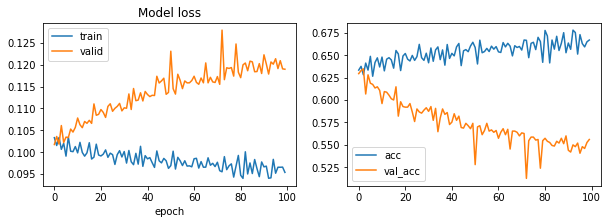

In [10]:
f = plt.figure(figsize=(10, 3))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)

ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_title('Model loss')
ax.set_xlabel('epoch')
ax.legend(['train', 'valid'], loc='upper left')

ax2.plot(history.history['acc'])
ax2.plot(history.history['val_acc'])
ax2.legend(['acc', 'val_acc'])
ax2.plot()